[[1 0 1 0 0]
 [1 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 1]]


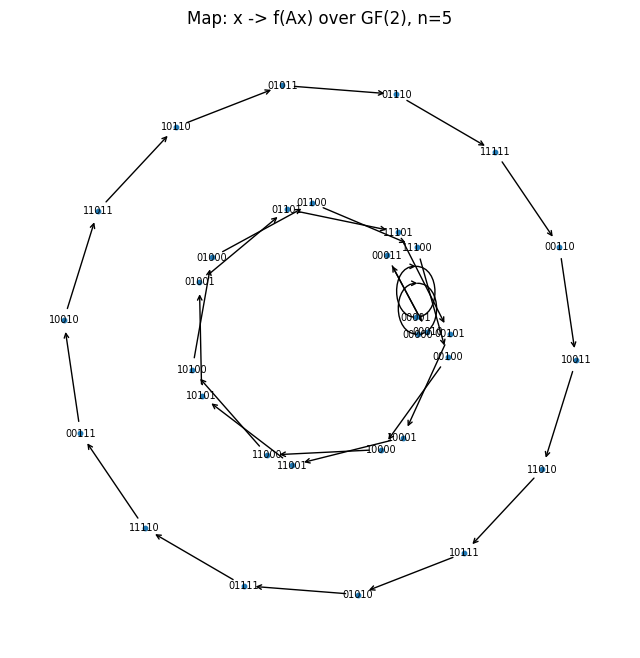

Matrix A (rows):
10100
11000
01000
00010
00011

Cycle lengths: [1, 1, 2, 7, 7, 14]
Number of cycles: 6

Trajectory from e1: 10000 -> 11000 -> 10100 -> 01000 -> 01100 -> 11100 -> 00100


In [264]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def gf2_rank(mat):
    M = mat.copy() % 2
    M = M.astype(int)
    rows, cols = M.shape
    r = 0
    for c in range(cols):
        pivot = None
        for i in range(r, rows):
            if M[i, c] == 1:
                pivot = i
                break
        if pivot is None:
            continue
        if pivot != r:
            M[[r, pivot]] = M[[pivot, r]]
        for i in range(r+1, rows):
            if M[i, c] == 1:
                M[i] ^= M[r]
        r += 1
        if r == rows:
            break
    return r

def int_to_vec(i, n):
    return tuple(((i >> (n-1-k)) & 1) for k in range(n))

def binary_to_gray(B):
    """
    Convert binary codes to Gray codes.
    B: ndarray of shape (..., n) with 0/1 ints
    """
    B = np.asarray(B) % 2
    G = B.copy()
    G[..., 1:] ^= B[..., :-1]
    return G


def gray_to_binary(G):
    """
    Convert Gray codes back to binary.
    G: ndarray of shape (..., n) with 0/1 ints
    """
    G = np.asarray(G) % 2
    B = G.copy()
    # cumulative XOR along the last axis
    for i in range(1, B.shape[-1]):
        B[..., i] ^= B[..., i-1]
    return B

def debruijn_sequence(x):
    n = len(x)
    a = [0] * (2*n)
    seq = []

    def db(t, p):
        if t > n:
            if n % p == 0:
                seq.extend(a[1:p+1])
        else:
            a[t] = a[t - p]
            db(t + 1, p)
            for j in range(a[t - p] + 1, 2):
                a[t] = j
                db(t + 1, t)

    db(1, 1)
    return np.array(seq, dtype=np.uint8)  # length = 2**n


def windows_from_debruijn(B):
    n = int(np.log2(len(B)))
    window_map = {}
    window_list = []

    for i in range(len(B)):
        w = tuple(int(B[(i+j) % len(B)]) for j in range(n))
        window_map[w] = i
        window_list.append(w)

    return window_map, window_list


def binary_to_bruijn(x):
    """
    Given a binary array x, return its index as a binary numpy array (one-hot style)
    in the de Bruijn cycle of length 2**n.
    """
    B = debruijn_sequence(x)
    window_map, _ = windows_from_debruijn(B)
    n = len(x)
    L = 2**n
    idx = window_map[tuple(int(b) for b in x)]
    
    # Convert index to binary array of length n
    idx_bin = np.array(list(np.binary_repr(idx, width=n)), dtype=np.uint8)
    return idx_bin


def bruijn_to_binary(idx_bin):
    """
    Given a binary np array idx_bin (from binary_to_bruijn),
    recover the original n-bit window.
    """
    n = len(idx_bin)
    idx = int("".join(idx_bin.astype(str)), 2)
    # Use a dummy array of length n to generate de Bruijn sequence
    x_dummy = np.zeros(n, dtype=np.uint8)
    B = debruijn_sequence(x_dummy)
    _, window_list = windows_from_debruijn(B)
    return np.array(window_list[idx], dtype=np.uint8)


def bitwise_not_bits(X):
    """
    Bitwise NOT for an array of binary bits (0/1).
    Returns 1-X.
    """
    X = np.asarray(X) % 2
    return 1 - X

def f(x):
    # TODO: search for such a good f(x) that it somehow improves the expected time to recover
    #    intuition why it may help: it mixes up the bits more nonlinearly
    # for now a example of a tromandous monster we can apply
    return x # binary_to_gray(bruijn_to_binary(gray_to_binary(bitwise_not_bits(binary_to_bruijn((x + 7) % 2)))))

def apply_rule(A, x):
    x_arr = np.array(x, dtype=int)
    y = f(A.dot(x_arr) % 2)
    return tuple(int(b) for b in y)

def build_graph(A):
    n = A.shape[0]
    nodes = [int_to_vec(i, n) for i in range(2**n)]
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for x in nodes:
        y = apply_rule(A, x)
        G.add_edge(x, y)
    return G

def cycle_decomposition(A):
    n = A.shape[0]
    visited = set()
    cycles = []
    for i in range(2**n):
        v = int_to_vec(i, n)
        if v in visited:
            continue
        path = []
        cur = v
        while cur not in path:
            path.append(cur)
            cur = apply_rule(A, cur)
        idx = path.index(cur)
        cycle = path[idx:]
        for node in path:
            visited.add(node)
        cycles.append(cycle)
    return cycles

def gray_matrix_right_shift(n):
    # G = I + shift_right (zero-fill)
    G = np.eye(n, dtype=np.uint8)
    for i in range(n-1):
        G[i, i+1] = 1
    return G  # entries 0/1 (use XOR or mod2 after multiplication)

def gray_matrix_left_shift(n):
    G = np.eye(n, dtype=np.uint8)
    for i in range(1, n):
        G[i, i-1] = 1
    return G


def random_invertible_matrix(n, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Random u in {0,1}^n as column vector
    u = np.random.randint(0, 2, (n, 1), dtype=int)

    # GF(2) bitwise NOT: v = 1 - u
    v = 1 - u % 2

    # Identity matrix and Gray left shift matrix
    I = np.eye(n, dtype=int)
    G = gray_matrix_left_shift(n)

    # A = I + u v^T  in GF(2): addition is XOR
    A = I ^ (u @ v.T) % 2

    # Update A = GA
    A = G@A % 2

    return A

# Parameters
n = 5
A = random_invertible_matrix(n)
print(A)
G = build_graph(A)
cycles = cycle_decomposition(A)

start = int_to_vec(1 << (n-1), n)  # e1 = 10000
traj = []
cur = start
seen = set()
while cur not in seen:
    seen.add(cur)
    traj.append(cur)
    cur = apply_rule(A, cur)

# Plot
plt.figure(figsize=(8, 8))
pos = nx.kamada_kawai_layout(G)
labels = {node: ''.join(str(int(b)) for b in node) for node in G.nodes()}
nx.draw_networkx_nodes(G, pos, node_size=10)
nx.draw_networkx_labels(G, pos, labels, font_size=7)
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', arrowsize=8)
plt.title("Map: x -> f(Ax) over GF(2), n=5")
plt.axis('off')
plt.show()

# Print matrix and stats
print("Matrix A (rows):")
for row in A:
    print(''.join(str(int(b)) for b in row))

print("\nCycle lengths:", sorted([len(c) for c in cycles]))
print("Number of cycles:", len(cycles))
print("\nTrajectory from e1:", ' -> '.join(''.join(str(int(b)) for b in v) for v in traj))